In [1]:
!python --version

Python 3.7.16


In [1]:
import os
os.chdir("..")
from rice import Rice

from tqdm import tqdm

import helper_scripts
from PPO import PPO

In [2]:
env = Rice(region_yamls_filename='fewer_region_yamls/')

In [3]:
agents = helper_scripts.create_agents(env)

In [4]:
n_parallel_envs = 4
envs = [Rice(region_yamls_filename='fewer_region_yamls/') for _ in range(n_parallel_envs)]

In [5]:
epochs = 20
batch_size = 16

In [6]:
rewards_collection = {i : [] for i in range(len(agents))}

for epoch in tqdm(range(epochs)):
    for batch in range(batch_size):
        states = [env.reset() for env in envs]
        for t in range(env.episode_length):
            collective_action = {}
            for agent_id in range(len(agents)):
                collective_action[agent_id] = agents[agent_id].select_action(
                    [state[agent_id] for state in states]
                )
                
            states, rewards, _, _ = zip(*[
                env.step({agent_id : collective_action[agent_id][i] 
                          for agent_id in range(len(agents))}) 
                for (i, env) in enumerate(envs)
            ])
            
            for agent_id in range(len(agents)):
                r = [reward[agent_id] for reward in rewards]
                agents[agent_id].buffer.rewards.extend(r)    
                rewards_collection[agent_id].extend(r)
                agents[agent_id].buffer.is_terminals.extend([t == env.episode_length - 1] * n_parallel_envs)

    for agent in agents:
        agent.update()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:02<00:00,  6.11s/it]


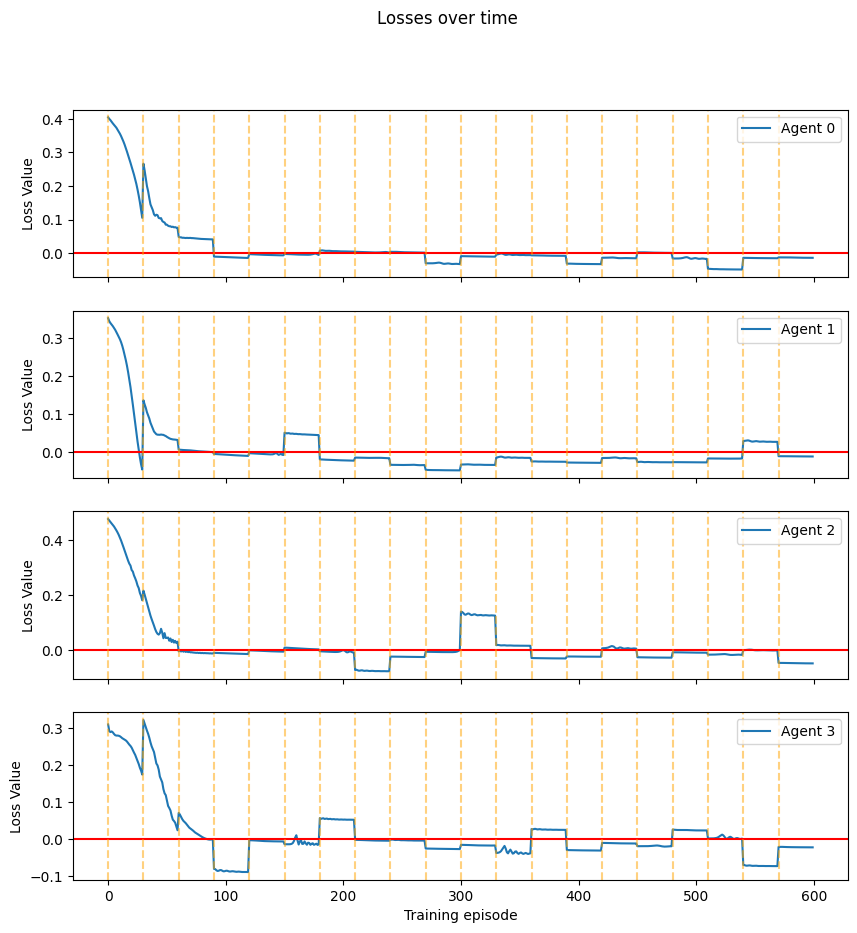

In [9]:
helper_scripts.plot_losses(agents, agents[0].params['K_epochs'])

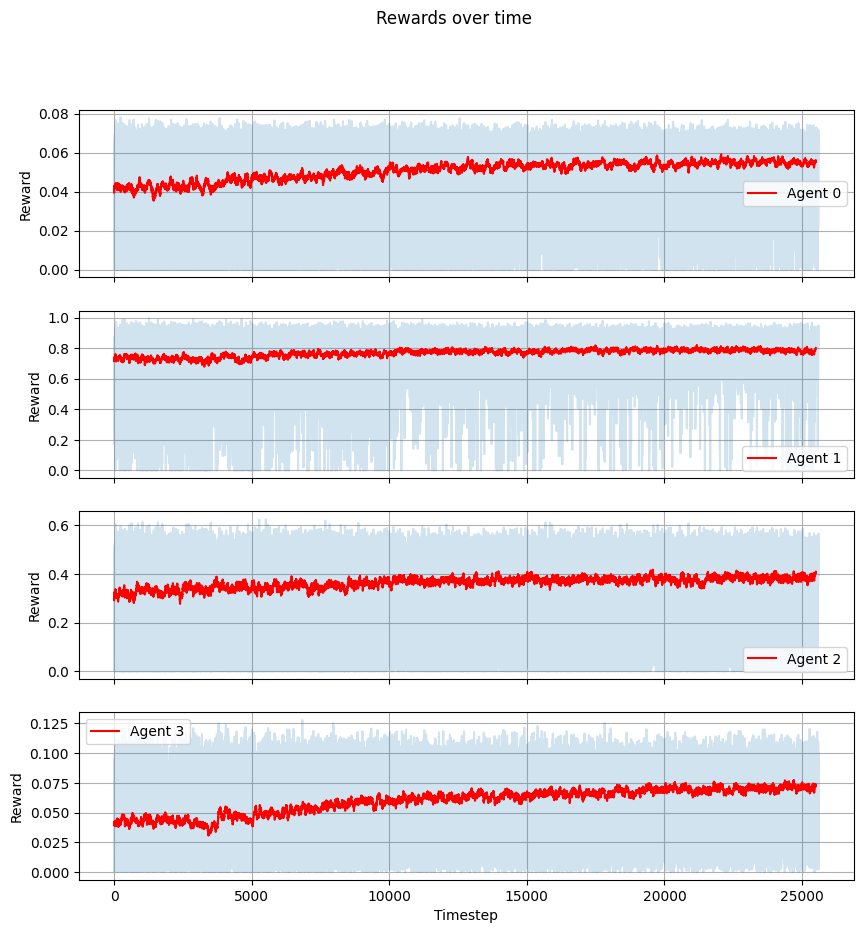

In [10]:
helper_scripts.plot_rewards(rewards_collection)

In [11]:
t, a_t, _ = helper_scripts.evaluate_agents(agents, env)
b, a_b, _ = helper_scripts.baseline(env)

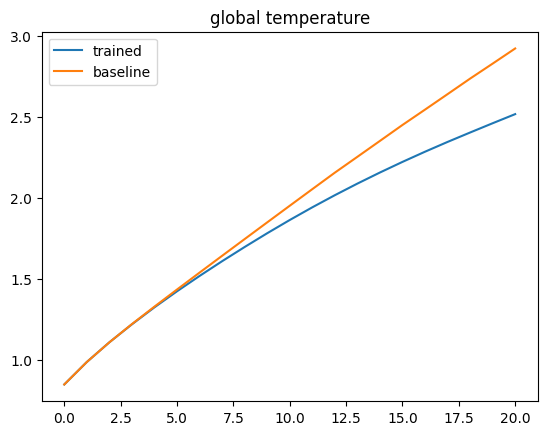

In [12]:
import matplotlib.pyplot as plt
plt.plot(t['global_temperature']['value'][:, 0], label = 'trained')
plt.plot(b['global_temperature']['value'][:, 0], label = 'baseline')
plt.legend()
plt.title('global temperature')
plt.show()

In [15]:
env.action_space

{0: MultiDiscrete([10 10 10 10 10 10 10 10 10 10 10]),
 1: MultiDiscrete([10 10 10 10 10 10 10 10 10 10 10]),
 2: MultiDiscrete([10 10 10 10 10 10 10 10 10 10 10]),
 3: MultiDiscrete([10 10 10 10 10 10 10 10 10 10 10])}

In [16]:
env.actions_nvec

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]